In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df = pd.read_csv('Data/monthly-milk-production.csv')

In [33]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [34]:
df.rename(columns ={'Monthly milk production: pounds per cow. Jan 62 ? Dec 75': 'Milk produced'}, inplace=True)

In [35]:
df.head()

,Month,Milk produced
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [36]:
df.tail()

,Month,Milk produced
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [37]:
df.drop(168,axis = 0,inplace = True)

In [38]:
df['Month'] = pd.to_datetime(df['Month'])

In [39]:
df.set_index('Month',inplace=True)

In [40]:
df.shape

(168, 1)

In [41]:
df.head()

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [42]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk produced,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


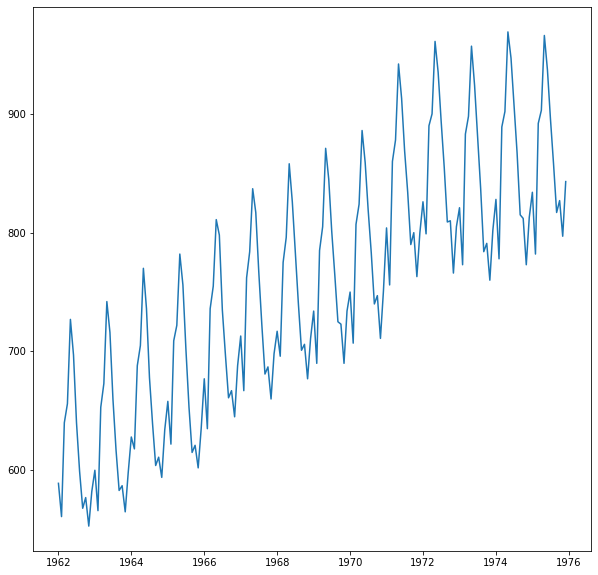

In [43]:
plt.figure(figsize=(10,10))
plt.plot(df['Milk produced'])

In [44]:
timeseries = df['Milk produced']

In [45]:
type(timeseries)

pandas.core.series.Series

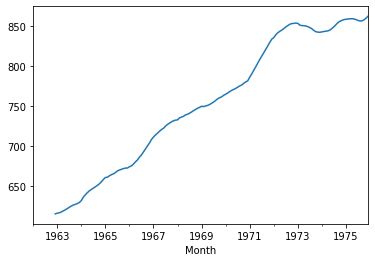

In [46]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')

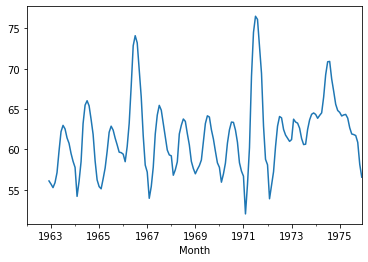

In [47]:
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')

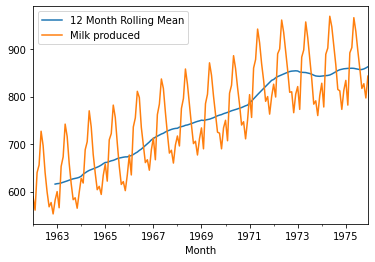

In [48]:
timeseries.rolling(12).mean().plot(label = '12 Month Rolling Mean')
timeseries.plot()
plt.legend()

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose #### classical decomposition

In [50]:
decomposition = seasonal_decompose(df['Milk produced'], freq=12)  

<ipython-input-50-fb1c3419a71a>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df['Milk produced'], freq=12)


<Figure size 432x288 with 0 Axes>

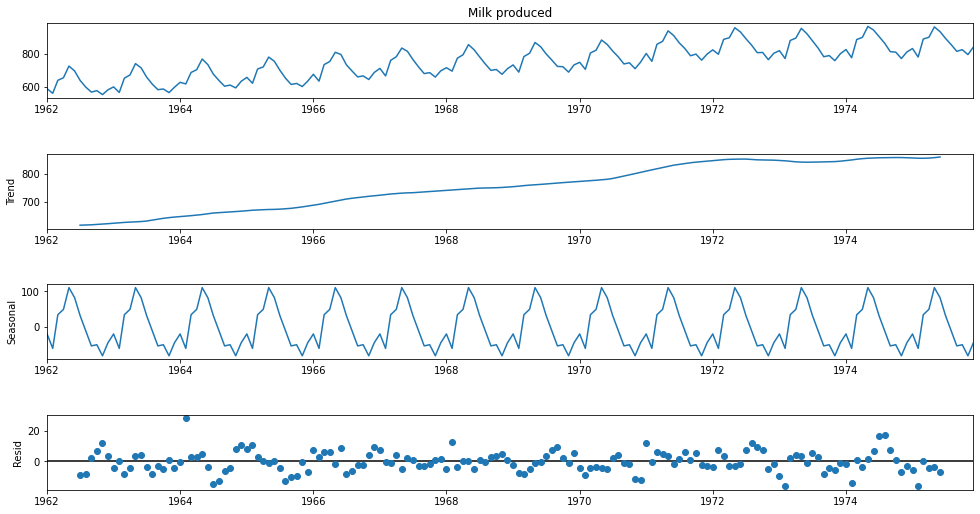

In [51]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [52]:
df.head()

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [55]:
result = adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221246
p-value : 0.627426708603034
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [56]:
df['Milk produced'] #### yt

Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01    827.0
1975-11-01    797.0
1975-12-01    843.0
Name: Milk produced, Length: 168, dtype: float64

In [57]:
df['Milk produced'].shift(1) #### yt-1

Month
1962-01-01      NaN
1962-02-01    589.0
1962-03-01    561.0
1962-04-01    640.0
1962-05-01    656.0
              ...  
1975-08-01    896.0
1975-09-01    858.0
1975-10-01    817.0
1975-11-01    827.0
1975-12-01    797.0
Name: Milk produced, Length: 168, dtype: float64

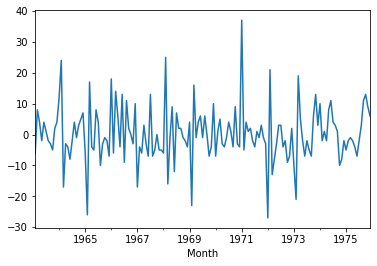

In [58]:
  #### First order normal differencing

trend_removed = df['Milk produced'] - df['Milk produced'].shift(1) #### first order normal differencing

trend_seasonality_removed = trend_removed - trend_removed.shift(12) #### First order seasonal differencing

trend_seasonality_removed = trend_seasonality_removed.dropna()

trend_seasonality_removed.plot()

In [59]:
print(adf_check(trend_seasonality_removed)) ### first order seasonal differencing and first order trend differencing

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921979
p-value : 1.865423431878876e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
None


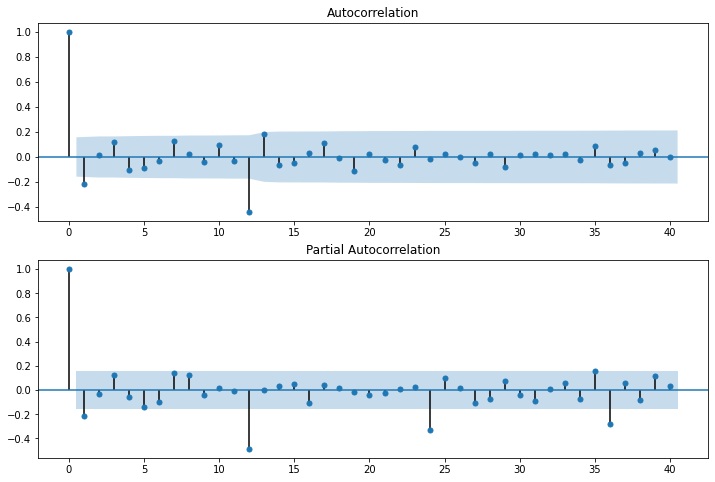

In [60]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_seasonality_removed,lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_seasonality_removed,lags = 40, ax = ax2)

In [61]:
model = sm.tsa.statespace.SARIMAX(df['Milk produced'],order = (1,1,0),seasonal_order = (0,1,1,12))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [62]:
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Milk produced   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Thu, 05 Jan 2023   AIC                           1066.207
Time:                                      15:12:26   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.61

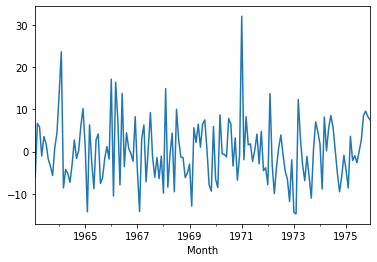

In [63]:
results.resid[13:].plot()

In [65]:
len(df['Milk produced'])

168

In [66]:
results.predict(start= 128, end = 138,dynamic = True) ### forecast the value for 118th month using the model

1972-09-01    813.696890
1972-10-01    820.136163
1972-11-01    786.736139
1972-12-01    825.306337
1973-01-01    855.814105
1973-02-01    819.315441
1973-03-01    914.412100
1973-04-01    929.652928
1973-05-01    991.751129
1973-06-01    964.960377
1973-07-01    921.717331
Freq: MS, Name: predicted_mean, dtype: float64

In [67]:
results.predict(start= 168, end = 180,dynamic = True)

1976-01-01     865.349739
1976-02-01     818.387706
1976-03-01     925.019489
1976-04-01     938.096591
1976-05-01    1001.238546
1976-06-01     973.830260
1976-07-01     932.477681
1976-08-01     892.889158
1976-09-01     846.994443
1976-10-01     852.166204
1976-11-01     818.130555
1976-12-01     860.408590
1977-01-01     883.596821
Freq: MS, Name: predicted_mean, dtype: float64

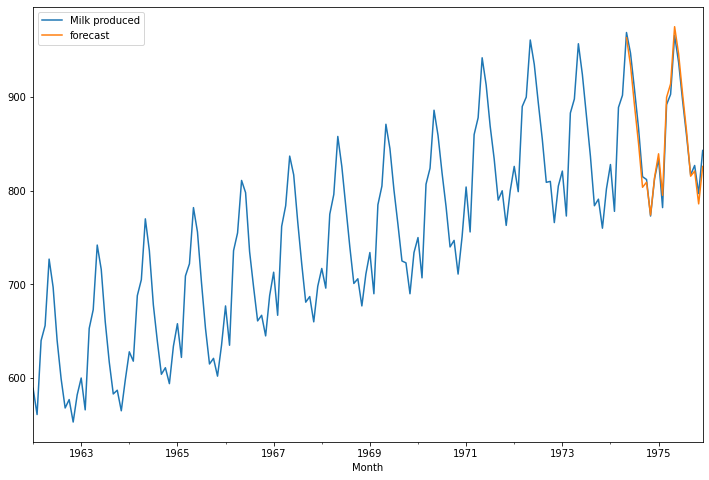

In [68]:
df['forecast'] = results.predict(start= 148, end = 168,dynamic = True)  
df[['Milk produced','forecast']].plot(figsize = (12, 8))

In [69]:
from pandas.tseries.offsets import DateOffset

In [70]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,14)]

In [71]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00')]

In [72]:
future_dates_df = pd.DataFrame(index = future_dates[1:],columns = df.columns)

In [73]:
future_df = pd.concat([df,future_dates_df])

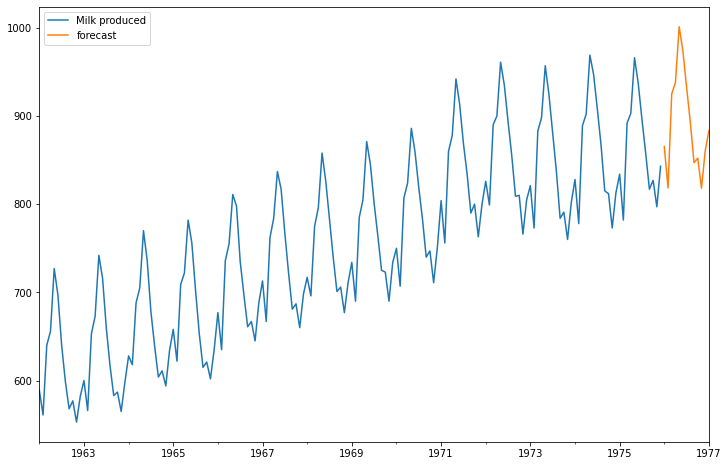

In [75]:
future_df['forecast'] = results.predict(start = 168, end = 180,dynamic= True)  
future_df[['Milk produced', 'forecast']].plot(figsize = (12, 8)) 